# Projeto Previsão de Churn Rate

### A pergunta inicial e se existe uma correlação entre as variaveis do data-set e com o qual precisão o modelo pode prever a porbabilidade de um cliente evadir

### Variaveis
- Churn: Yes or Not 
- Contract: Month-to-month , One year, Two year
- Dependents: Yes or Not
- DeviceProtection: Yes or Not
- InternetService: Fiber Optic, DSL, No 
- MonthlyCharges= How much the customer spent per month
- MultipleLines: Yes or Not
- OnlineBackup: Yes or Not 
- OnlineSecurity: Yes or Not
- PaperlessBilling: Yes or Not
- Partner: Yes or Not
- PaymentMethod: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)
- PhoneService: Yes or Not 
- SeniorCitizen: 0 or 1
- StreamingMovies: Yes or Not
- StreamingTV: Yes or Not
- TechSupport: Yes or Not
- TotalCharges= how much the customer spent in total
- customerID: ID
- gender: The customer is a male or a female
- tenure = Months The customer has stayed with the company

Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from scikitplot.metrics import plot_precision_recall_curve, plot_lift_curve, plot_cumulative_gain, plot_roc_curve, plot_ks_statistic
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
sns.set()

Chamando arquivo

In [7]:
df = pd.read_csv('C:/Users/Thiago/Desktop/Potifolio/Projeto Churn/data/Churn.csv')

Vendo tamanho do arquivo e informações do arquivo

### Análise exploratória

In [8]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
df.shape

(7043, 21)

### Preparação e limpeza dos dados

Primeiro vamos identificar commo os dados estão sendo lidos e se existe algum dado nulo

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Vimos que alguns dados que deveriam ser numericos estõa como objetos

Convertendo total charges em numerico e encontrando se há valores missing

In [11]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Agora que descobrimos Dados faltantes, vamos enteder os dados para podermos trata-los

In [12]:
df['TotalCharges'].sort_values().tail(11)

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: TotalCharges, dtype: float64

In [13]:
df['tenure'].value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

Vimos que existem 11 dados como 0 em tenure bem como 11 dados missing e total charges, sabendo que total charges = tenure * MonthlyCharges poderemos subistituir s dados faltantes com a função abaixo.

In [14]:
df[['tenure','MonthlyCharges','TotalCharges']].head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Agora vamos cofirmar que todos os dados faltantes em TotalCharges são mesmo os que correpondem a tenure 0

In [15]:
df.query('tenure=="0"').head(11)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Agora vamos retirar os dados missing simplesmente tranformando o 0 em 1 pois entendemos que os clientes com 0 assinaram o plano a menos de 1 mês mas já começaram a pagar.

In [16]:
df.loc[df['tenure']==0, 'tenure'] = 1

In [17]:
df['tenure'].value_counts()

1     624
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: tenure, Length: 72, dtype: int64

Agora vamos fazer o cauculo para acabar de vez com os dados missing.

Em seguida vamos ver se ainda existem dados faltantes.

In [18]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['tenure']*df['MonthlyCharges'])

In [19]:
df[['tenure','MonthlyCharges','TotalCharges']].head(489)

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65
...,...,...,...
484,8,83.55,680.05
485,72,84.50,6130.85
486,15,100.15,1415.00
487,72,88.60,6201.95


In [20]:
df.query('tenure=="0"').head(11)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Agora nos tranforaremos os dados que os clientes não tem determinado tipo de servço em não para podermos trabalhar com as variavris binarias.

In [21]:
df.loc[df['StreamingMovies']=='No internet service', 'StreamingMovies'] = 'No'
df.loc[df['StreamingTV']=='No internet service', 'StreamingTV'] = 'No'
df.loc[df['OnlineSecurity']=='No internet service', 'OnlineSecurity'] = 'No'
df.loc[df['OnlineBackup']=='No internet service', 'OnlineBackup'] = 'No'
df.loc[df['DeviceProtection']=='No internet service', 'DeviceProtection'] = 'No'
df.loc[df['TechSupport']=='No internet service', 'TechSupport'] = 'No'
df.loc[df['OnlineSecurity']=='No internet service', 'OnlineSecurity'] = 'No'
df.loc[df['MultipleLines']=='No phone service', 'MultipleLines'] = 'No'

### Vamos entender um pouco os dados antes de terminar a preparação

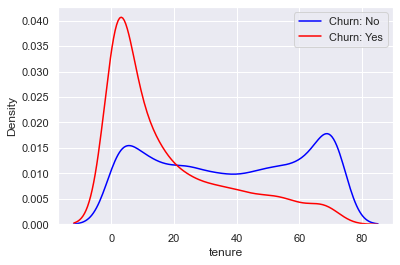

In [25]:
sns.kdeplot(df[df["Churn"]=='No']["tenure"],color='blue',label='Churn: No')
sns.kdeplot(df[df["Churn"]=='Yes']["tenure"],color='red',label='Churn: Yes')
plt.legend()
plt.show()

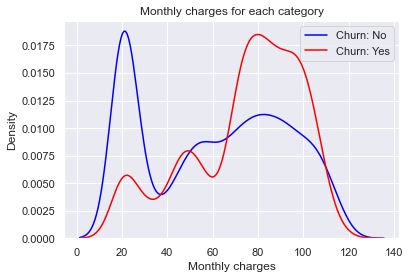

In [43]:
sns.kdeplot(df[df["Churn"]=='No']["MonthlyCharges"],color='blue',label='Churn: No')
sns.kdeplot(df[df["Churn"]=='Yes']["MonthlyCharges"],color='red',label='Churn: Yes')
plt.legend()
plt.title("Monthly charges for each category")
plt.xlabel("Monthly charges")
plt.show()

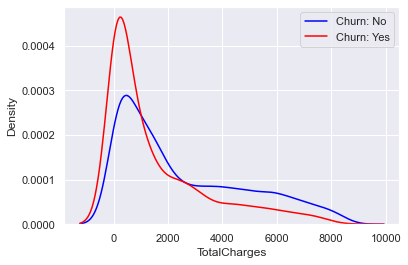

In [26]:
sns.kdeplot(df[df["Churn"]=='No']["TotalCharges"],color='blue',label='Churn: No')
sns.kdeplot(df[df["Churn"]=='Yes']["TotalCharges"],color='red',label='Churn: Yes')
plt.legend()
plt.show()

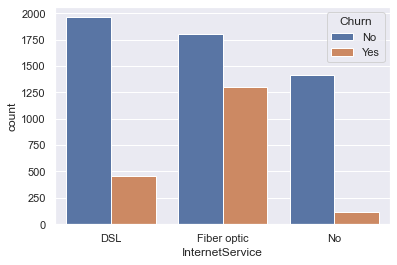

In [37]:
sns.countplot(x=df["InternetService"],hue=df["Churn"])

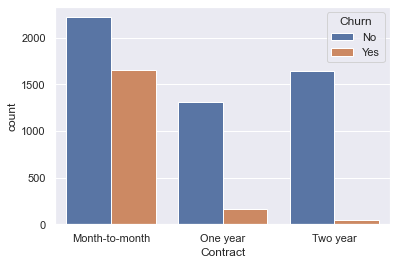

In [36]:
sns.countplot(x=df["Contract"],hue=df["Churn"])

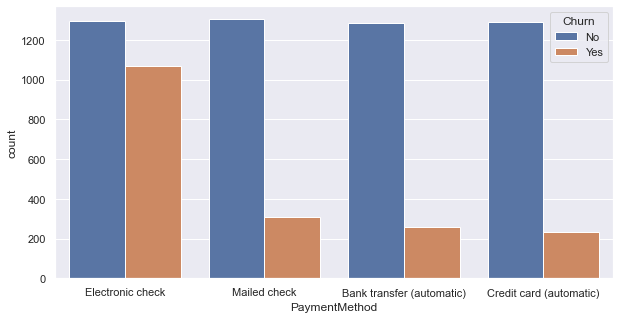

In [35]:
plt.figure(figsize=(10,5))
sns.countplot(x=df["PaymentMethod"],hue=df["Churn"])

<AxesSubplot:xlabel='gender', ylabel='count'>

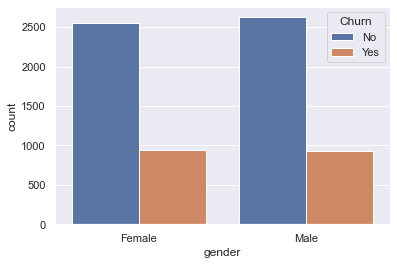

In [39]:
sns.countplot(x=df["gender"],hue=df["Churn"])

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

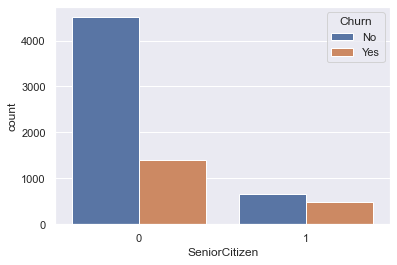

In [41]:
sns.countplot(x=df["SeniorCitizen"],hue=df["Churn"])

Vamos utilizar o ordinal encoder para tranormar as variaveis Yes ou No em Vairaveis Binarias ( 1 e 0)

In [18]:
transform = OrdinalEncoder()

In [19]:
col_bin = ['Churn','gender', 'Partner','Dependents','PhoneService','StreamingTV','PaperlessBilling','StreamingMovies','OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'OnlineSecurity', 'MultipleLines']
df[col_bin] = pd.DataFrame(pd.DataFrame(columns=col_bin, data=transform.fit_transform(df[col_bin])))

Agora tranformamos as colunas categoricas menos customerID em colunas fazendo com que as mesmas fquem com o argumento 0 para não tem e 1 para tem

In [20]:
Cat = ['InternetService', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=Cat)

### Agoa vamos após o tratamento vamos continuar a tratar os dados

Primeiro Vamos explorar a correlação das demais varivaeis com o o Churn

In [21]:
corr_matrix = df.corr()

In [22]:
corr_matrix["Churn"].sort_values(ascending=False)

Churn                                      1.000000
Contract_Month-to-month                    0.405103
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
StreamingTV                                0.063228
StreamingMovies                            0.061382
MultipleLines                              0.040102
PhoneService                               0.011942
gender                                    -0.008612
DeviceProtection                          -0.066160
OnlineBackup                              -0.082255
PaymentMethod_Mailed check                -0.091683
PaymentMethod_Bank transfer (automatic)   -0.117937
InternetService_DSL                       -0.124214
PaymentMethod_Credit card (automatic)     -0.134302
Partner                                   -0.150448
Dependents  

Notamos que a correlação mais forte está relacinada ao tipo de plano que o cliente assina, então amos investigar melhor

In [23]:
df[['tenure','Contract_Month-to-month','Contract_One year','Contract_Two year','Churn']].head(20)

,tenure,Contract_Month-to-month,Contract_One year,Contract_Two year,Churn
0,1,1,0,0,0.0
1,34,0,1,0,0.0
2,2,1,0,0,1.0
3,45,0,1,0,0.0
4,2,1,0,0,1.0
5,8,1,0,0,1.0
6,22,1,0,0,0.0
7,10,1,0,0,0.0
8,28,1,0,0,1.0
9,62,0,1,0,0.0


Vamos ver tambem se exste alguma relaçao com o valor total que o cliente gastou.

In [24]:
df[['tenure','TotalCharges', 'Churn']].head(20)

,tenure,TotalCharges,Churn
0,1,29.85,0.0
1,34,1889.50,0.0
2,2,108.15,1.0
3,45,1840.75,0.0
4,2,151.65,1.0
5,8,820.50,1.0
6,22,1949.40,0.0
7,10,301.90,0.0
8,28,3046.05,1.0
9,62,3487.95,0.0


Vamos agora ver a força das correlações com o churn atraves do scatterplot e como se comportam

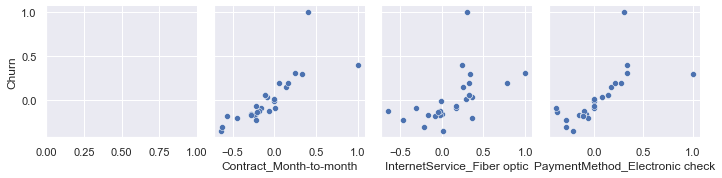

In [25]:
sns.pairplot(data=corr_matrix, x_vars=[" ","Contract_Month-to-month", "InternetService_Fiber optic", "PaymentMethod_Electronic check"], y_vars=["Churn"])

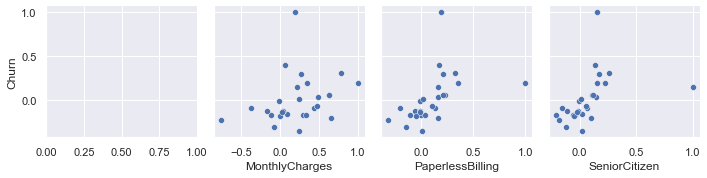

In [26]:
sns.pairplot(data=corr_matrix, x_vars=[" ","MonthlyCharges", "PaperlessBilling", "SeniorCitizen"], y_vars=["Churn"])

Notamos que algumas das correlações ainda que positivas são mais fracas que as outras como e o Caso de MontlyCharges diferente de SenuiorCitzen que apesar de ser uma correlação menor é mais forte.

Vamos analisar algumas variaveis em relação ao churn para entender melhor como os clientes se comprotam

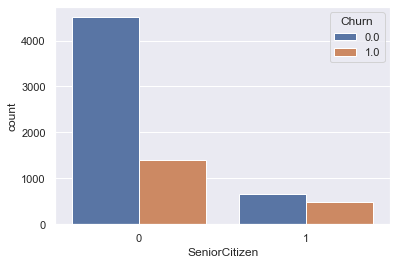

In [27]:
ax = sns.countplot(x="SeniorCitizen", hue="Churn", data=df)

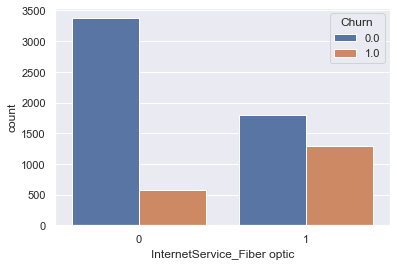

In [28]:
ax = sns.countplot(x="InternetService_Fiber optic", hue="Churn", data=df)

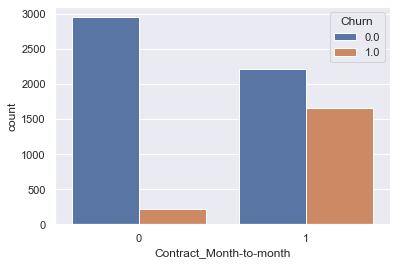

In [29]:
ax = sns.countplot(x="Contract_Month-to-month", hue="Churn", data=df)

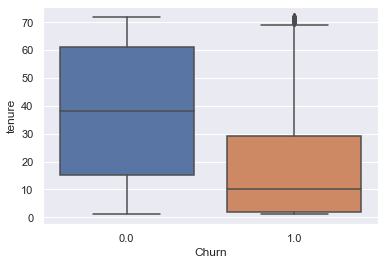

In [30]:
ax = sns.boxplot(y="tenure", x="Churn", data=df)

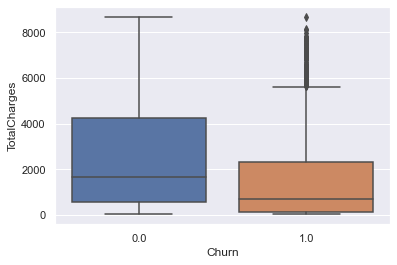

In [34]:
ax = sns.boxplot(y="TotalCharges", x="Churn", data=df)

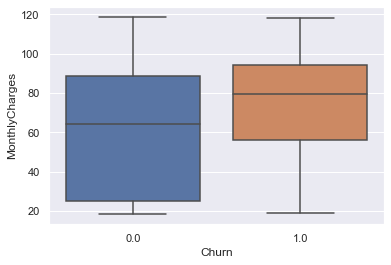

In [36]:
ax = sns.boxplot(y="MonthlyCharges", x="Churn", data=df)

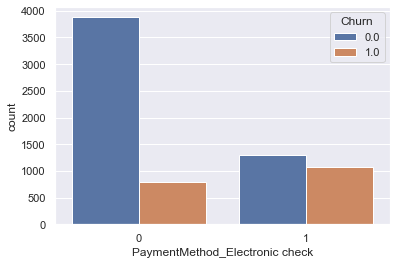

In [38]:
ax = sns.countplot(x="PaymentMethod_Electronic check", hue="Churn", data=df)

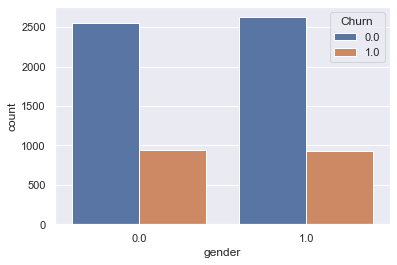

In [33]:
ax = sns.countplot(x="gender", hue="Churn", data=df)

Vamos enteder os graficos?

1º pessoas que não cidadões seniores tem maior aderencia comparado aos seniroes e se mantem mais fieis.

2º Existem algum problema com a internet de fibra otica, muitas pessoas que a tem acabam sendo churn.

3º Pessoas com contrato mensal tem maior probabilidade de serem churn.

4º A media de gasto mensal não apresenta grandes diferenças entre os grupos.

5º Pessoas que não tem metodo de pagamento Electronic check tem mais chances continuar com os serviços.

6º O genero do cliente não influencia para ser chune ou não.

### Construção do modelo

Primeiramente vamos retirar as variaveis que não vão influencias na contrução do modelo.

In [34]:
df2 = df.drop("customerID", axis=1)

Vamos seprar em X as varaveis para previsão
e Y o Target

In [35]:
X = df2.drop("Churn", axis=1)
Y = df2["Churn"]

Vamos seprar os cojunto de treino e teste na promoçar 80/20 respectivamente

In [36]:
X_train , X_test , Y_train, Y_test = train_test_split(X,Y ,random_state=42, test_size=0.2, stratify=Y)

Vamos definir quais modelos vamos treinar

In [36]:
lreg = LogisticRegression(max_iter=200)
tree_clas = ExtraTreesClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
cat = CatBoostClassifier(verbose=False)

Agora vamos executar os treinamentos dos modelos para depois ver sua acuracia

Alguns modelos foram calibrados para melhorar sau eficacia

In [37]:
lreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
Y_lreg_pred = lreg.predict(X_test)
Y_lreg_pred_proba = lreg.predict_proba(X_test)
Y_lreg_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [39]:
Y_lreg_pred==Y_test

437      True
2280    False
2235     True
4460     True
3761     True
        ...  
5143     True
4439     True
3857     True
4758     True
5613     True
Name: Churn, Length: 1409, dtype: bool

Fazer a calibração do modelo

In [40]:
calibrated_tree = CalibratedClassifierCV(base_estimator=tree_clas, cv=3)
calibrated_tree.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                           ccp_alpha=0.0,
                                                           class_weight=None,
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                      

In [41]:
y_tree_pred = calibrated_tree.predict(X_test)
y_tree_pred_proba = calibrated_tree.predict_proba(X_test)
y_tree_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [42]:
Y_test.values

array([0., 0., 0., ..., 0., 0., 0.])

In [43]:
calibrated_rf = CalibratedClassifierCV(base_estimator=rf, cv=3)
calibrated_rf.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=None,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                               

In [44]:
y_rf_pred = calibrated_rf.predict(X_test)
y_rf_pred_proba = calibrated_rf.predict_proba(X_test)
y_rf_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [45]:
calibrated_xgb = CalibratedClassifierCV(base_estimator=xgb, cv=3)
calibrated_xgb.fit(X_train, Y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:12:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:12:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:12:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    gamma=None, gpu_id=None,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                                    missing=nan,
                                                   

In [46]:
y_xgb_pred = calibrated_xgb.predict(X_test)
y_xgb_pred_proba = calibrated_xgb.predict_proba(X_test)
y_xgb_pred

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


array([0., 1., 0., ..., 0., 0., 0.])

In [47]:
y_xgb_pred_proba

array([[0.9024831 , 0.0975169 ],
       [0.19064144, 0.80935856],
       [0.85357363, 0.14642637],
       ...,
       [0.88070028, 0.11929972],
       [0.84317985, 0.15682015],
       [0.90304769, 0.09695231]])

In [48]:
calibrated_cat = CalibratedClassifierCV(base_estimator=cat)
calibrated_cat.fit(X_train,Y_train)

CalibratedClassifierCV(base_estimator=<catboost.core.CatBoostClassifier object at 0x00000222DF00FDF0>,
                       cv=None, method='sigmoid')

In [49]:
y_cat_pred = calibrated_cat.predict(X_test)
y_cat_pred_proba = calibrated_cat.predict_proba(X_test)
y_cat_pred

array([0., 1., 0., ..., 0., 0., 0.])

### Avaliação do modelo

Agora vamos medir os resultados para ver a eficacia dos modelos

In [50]:
print(classification_report(Y_test, Y_lreg_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1035
         1.0       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [51]:
print(classification_report(Y_test, y_tree_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      1035
         1.0       0.65      0.40      0.50       374

    accuracy                           0.78      1409
   macro avg       0.73      0.66      0.68      1409
weighted avg       0.77      0.78      0.77      1409



In [52]:
print(classification_report(Y_test, y_rf_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      1035
         1.0       0.65      0.45      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [53]:
print(classification_report(Y_test, y_xgb_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      1035
         1.0       0.65      0.45      0.53       374

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [54]:
print(classification_report(Y_test, y_cat_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      1035
         1.0       0.69      0.50      0.58       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



Notamos que alguns modelos se sairam melhores que outros

Vamos ver ver mais a fundo e depois fazer a otimização

AUC Acima de 0.5

AUC abaixo de 0.5 chute

In [55]:
roc_auc_score(Y_test, lreg.predict_proba(X_test)[:, 1])

0.8428530832622904

In [56]:
roc_auc_score(Y_test, calibrated_tree.predict_proba(X_test)[:, 1])

0.8177323103154305

In [57]:
roc_auc_score(Y_test, calibrated_rf.predict_proba(X_test)[:, 1])

0.8332041644062105

In [58]:
roc_auc_score(Y_test, calibrated_xgb.predict_proba(X_test)[:, 1])

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


0.8299206902787465

In [59]:
roc_auc_score(Y_test, calibrated_cat.predict_proba(X_test)[:, 1])

0.8432044227440647

Precsion Plot

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

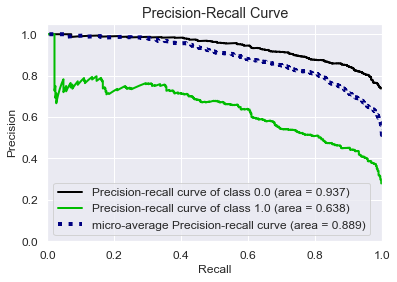

In [60]:
plot_precision_recall_curve(Y_test ,Y_lreg_pred_proba)

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

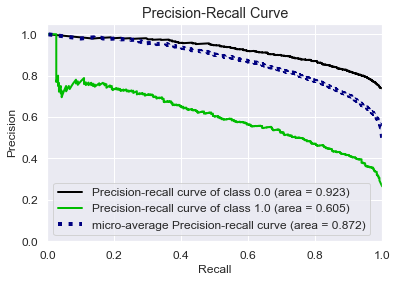

In [61]:
plot_precision_recall_curve(Y_test ,y_tree_pred_proba)

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

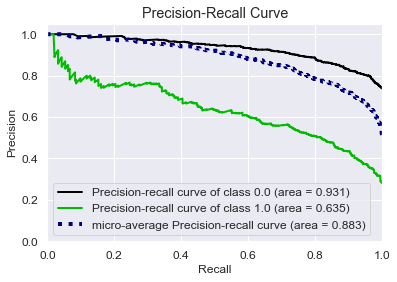

In [62]:
plot_precision_recall_curve(Y_test ,y_rf_pred_proba)

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

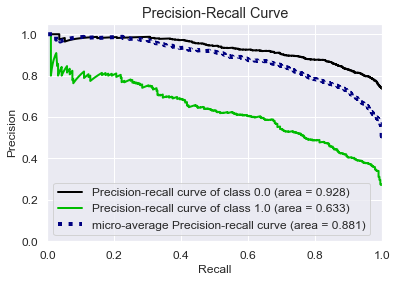

In [63]:
plot_precision_recall_curve(Y_test ,y_xgb_pred_proba)

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

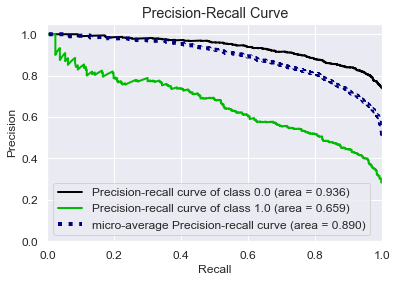

In [64]:
plot_precision_recall_curve(Y_test ,y_cat_pred_proba)

ROC Curve

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

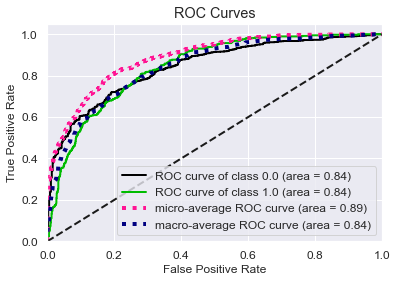

In [65]:
plot_roc_curve(Y_test, Y_lreg_pred_proba)

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

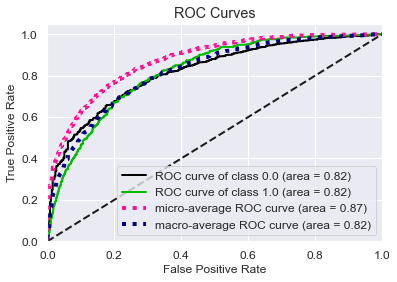

In [66]:
plot_roc_curve(Y_test, y_tree_pred_proba)

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

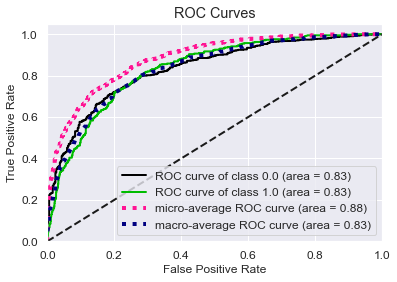

In [67]:
plot_roc_curve(Y_test, y_rf_pred_proba)

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

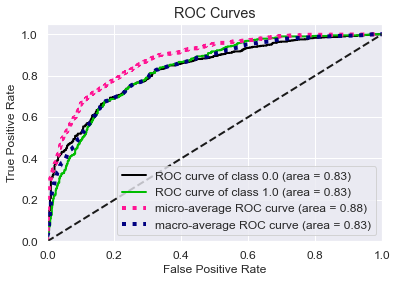

In [68]:
plot_roc_curve(Y_test, y_xgb_pred_proba)

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

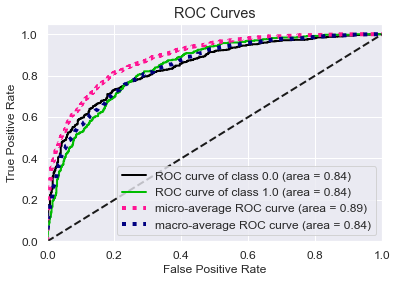

In [69]:
plot_roc_curve(Y_test, y_cat_pred_proba)

ks_statistic

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

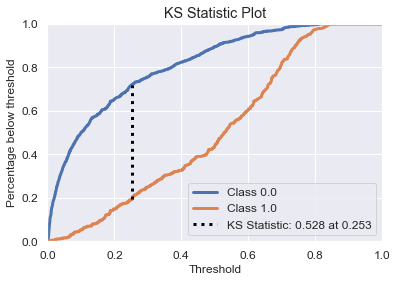

In [70]:
plot_ks_statistic(Y_test, Y_lreg_pred_proba)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

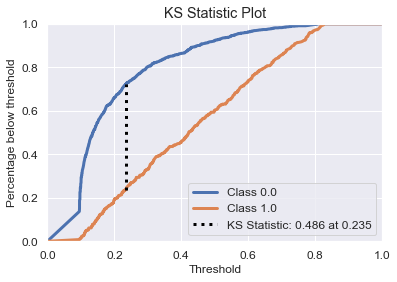

In [71]:
plot_ks_statistic(Y_test, y_tree_pred_proba)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

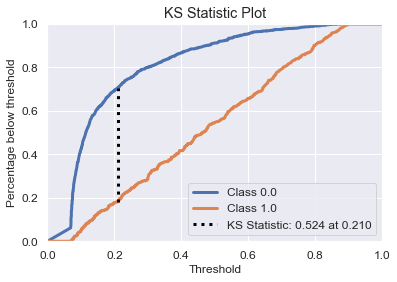

In [72]:
plot_ks_statistic(Y_test, y_rf_pred_proba)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

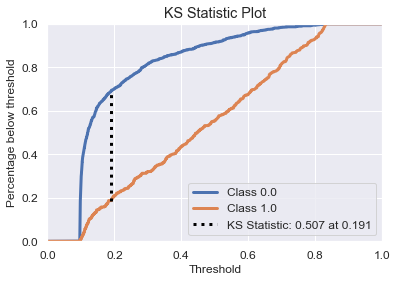

In [73]:
plot_ks_statistic(Y_test, y_xgb_pred_proba)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

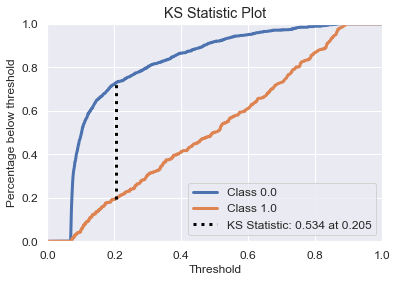

In [74]:
plot_ks_statistic(Y_test, y_cat_pred_proba)

### Otimização do modelo

Agora vamos ver quais são os melhores parametros de cada modelo e treinar os mesmos novamente.

Assim fazendo sua otimização.

In [75]:
param_lreg = [{'max_iter':[10,20,50,100],'n_jobs':[10,20,30,40], 'random_state':[42]}]
param_tree = [{'n_estimators' : [50 , 100 , 150,200],'max_depth' : [4,5,6,7,8,9, 10]}]
param_rf = [{'n_estimators' : [50 , 100 , 150,200],'max_depth' : [4,5,6,7,8,9, 10]}]
param_b = [{'n_estimators' : [50 , 100 , 150,200],'max_depth' : [4,5,6,7,8,9, 10]
                ,'learning_rate' : [0.001, 0.01 ,0.02,0.5,1]}]

Vamos Rodas o GridSearchCV um poderoso algoritimo de otimização que funciona traves do metodo de validação cruzada

In [76]:
grid_lreg= GridSearchCV(lreg, param_lreg, return_train_score=True)

In [77]:
    grid_lreg.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_iter': [10, 20, 50, 100],
                          'n_jobs': [10, 20, 30, 40], 'random_state': [42]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [78]:
grid_tree= GridSearchCV(tree_clas, param_tree, return_train_score=True)

In [79]:
grid_tree.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprec

In [80]:
grid_rf= GridSearchCV(tree_clas, param_rf, return_train_score=True)

In [81]:
grid_rf.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprec

In [82]:
grid_xgb = GridSearchCV(xgb, param_b, return_train_score=True, verbose=False)

In [83]:
grid_xgb.fit(X_train, Y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


[09:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
                                     validate_parameters=None, verbosity=N

In [84]:
grid_cat = GridSearchCV(cat, param_b, return_train_score=True, verbose=False)

In [85]:
grid_cat.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000222DF00FDF0>,
             iid='deprecated', n_jobs=None,
             param_grid=[{'learning_rate': [0.001, 0.01, 0.02, 0.5, 1],
                          'max_depth': [4, 5, 6, 7, 8, 9, 10],
                          'n_estimators': [50, 100, 150, 200]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=False)

Vamos retirar os melhores parametros de cada modelo.

In [86]:
grid_lreg.best_params_

{'max_iter': 100, 'n_jobs': 10, 'random_state': 42}

In [87]:
grid_tree.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [88]:
grid_rf.best_params_

{'max_depth': 10, 'n_estimators': 150}

In [89]:
grid_xgb.best_params_

{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 200}

In [90]:
grid_cat.best_params_

{'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 200}

Agora vamos treinar novamente os modelos, porém utilizando os melhores parametros de cada modelo.

In [113]:
lreg_opt = LogisticRegression(max_iter = 100, n_jobs = 10, random_state = 42)
tree_opt = ExtraTreesClassifier(max_depth = 8, n_estimators=50)
rf_opt = RandomForestClassifier(max_depth = 10, n_estimators=150)
xgb_opt = XGBClassifier(learning_rate = 0.02, max_depth = 4, n_estimators = 200)
cat_opt = CatBoostClassifier(learning_rate = 0.02, max_depth = 5, n_estimators = 200, verbose=False)

In [114]:
lreg_opt.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=10, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [115]:
y_lop_pred = lreg_opt.predict(X_test)
y_lop_pred_proba = lreg_opt.predict_proba(X_test)
y_lop_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [116]:
tree_opt.fit(X_train, Y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=8, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [117]:
y_top_pred = tree_opt.predict(X_test)
y_top_pred_proba = tree_opt.predict_proba(X_test)
y_top_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [118]:
rf_opt.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [119]:
y_rop_pred = rf_opt.predict(X_test)
y_rop_pred_proba = rf_opt.predict_proba(X_test)
y_rop_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [120]:
xgb_opt.fit(X_train, Y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:18:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=2, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [121]:
y_xop_pred = xgb_opt.predict(X_test)
y_xop_pred_proba = xgb_opt.predict_proba(X_test)
y_xop_pred

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


array([0., 1., 0., ..., 0., 0., 0.])

In [122]:
cat_opt.fit(X_train, Y_train)

In [123]:
y_cop_pred = cat_opt.predict(X_test)
y_cop_pred_proba = cat_opt.predict_proba(X_test)
y_cop_pred

array([0., 1., 0., ..., 0., 0., 0.])

Vamos ver se obtivemos alguma melhora?

In [124]:
print(classification_report(Y_test, y_lop_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1035
         1.0       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [125]:
print(classification_report(Y_test, y_top_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1035
         1.0       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [126]:
print(classification_report(Y_test, y_rop_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1035
         1.0       0.66      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [127]:
print(classification_report(Y_test, y_xop_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1035
         1.0       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [128]:
print(classification_report(Y_test, y_cop_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      1035
         1.0       0.68      0.51      0.58       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



Agora que vimos uma melhora em praticamente todos os modelos, vamos ver qual está melhor?

In [129]:
roc_auc_score(Y_test, lreg_opt.predict_proba(X_test)[:, 1])

0.8428634167764603

In [130]:
roc_auc_score(Y_test, tree_opt.predict_proba(X_test)[:, 1])

0.8348123175488904

In [131]:
roc_auc_score(Y_test, rf_opt.predict_proba(X_test)[:, 1])

0.8416169366297243

In [132]:
roc_auc_score(Y_test, xgb_opt.predict_proba(X_test)[:, 1])

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


0.8461055568472446

In [133]:
roc_auc_score(Y_test, cat_opt.predict_proba(X_test)[:, 1])

0.8478842129737271

In [136]:
#joblib.dump(xgb_opt, xgboost_treinado.joblib)

NameError: name 'xgboost_treinado' is not defined

Vamos salvar os dois melhores

In [153]:
xgb_opt.save_model("model_xgb.cbm")
cat_opt.save_model("model_cat.cbm")

In [ ]:
#joblib.load('/documents/models/xgboost_treinado.joblib')

Vamos chamar novamente atraves do carquivo salvo para não precisarmos treinar novamente antes de testar.

In [37]:
model = CatBoostClassifier()
model1 = XGBClassifier()
model.load_model("model_cat.cbm")
model1.load_model("model_xgb.cbm")

In [38]:
expl_xgb = shap.Explainer(model)
expl_cat = shap.Explainer(model1)
shap_xgb = expl_xgb(X)
shap_cat = expl_cat(X)

Agora vamos rodar alguns graficos pelo shap e ver como as variaveis se comprotam em cada modelo e suas diferenças

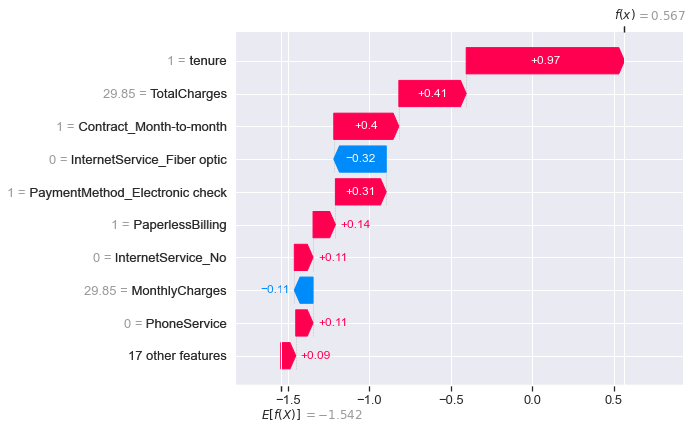

In [39]:
shap.plots.waterfall(shap_xgb[0])

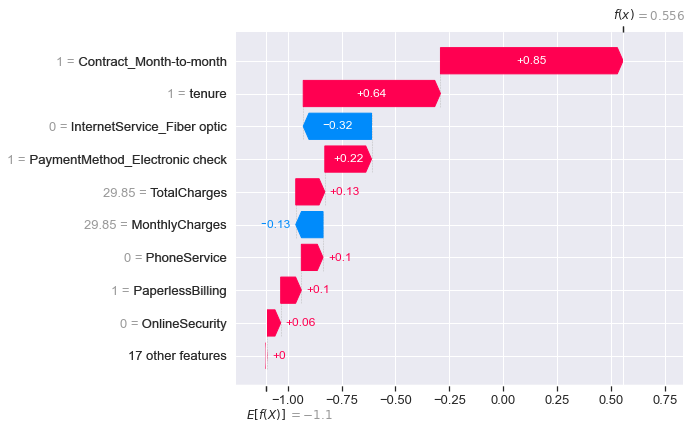

In [40]:
shap.plots.waterfall(shap_cat[0])

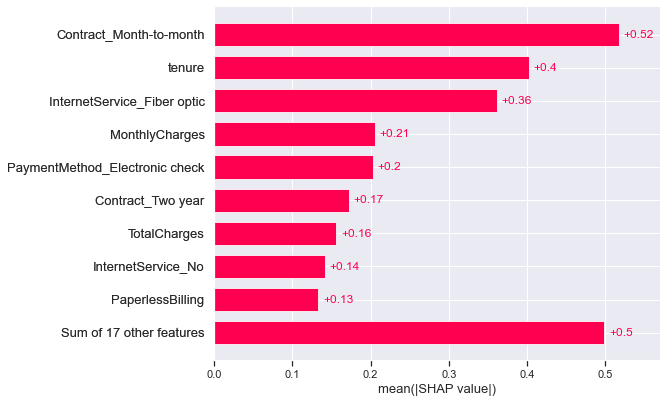

In [41]:
shap.plots.bar(shap_xgb)

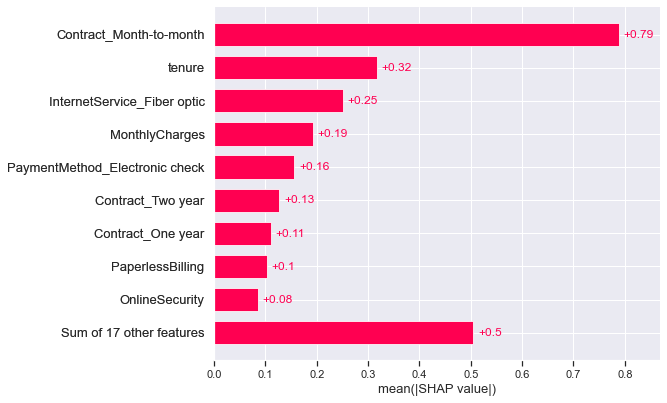

In [42]:
shap.plots.bar(shap_cat)

In [43]:
shap.initjs()
shap.plots.force(shap_xgb[0])

In [44]:
shap.initjs()
shap.plots.force(shap_cat[0])

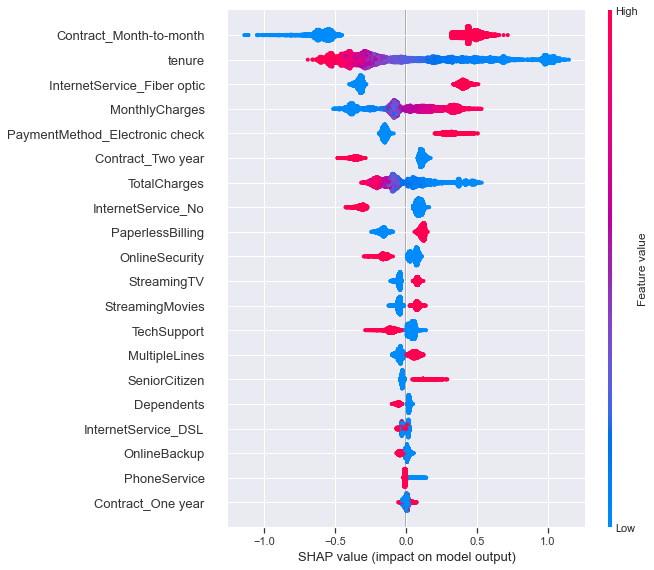

In [48]:
shap.initjs()
shap.summary_plot(shap_xgb, X)

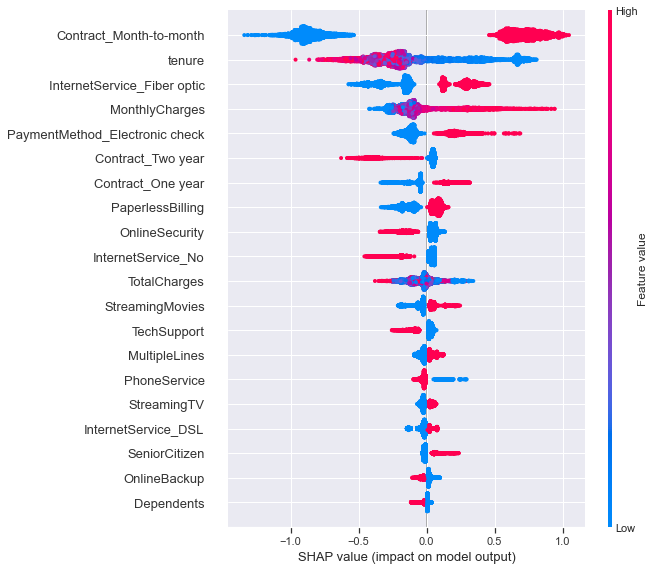

In [49]:
    shap.initjs()
    shap.summary_plot(shap_cat, X)

# Conclusão

Com base e toda a analise podemos observar que a maioria dos cliente que faziam churn são de plano mensal, com internet de fibraotica e com baixo periodo de uso emrelação ao quem não é churn, podemos treinar um modelo para prever quem serão os futuros churns para que possamos implementar ações ou melhorias para que esses clientes permaneçam utilizando os nossos serviços